# Homework №1: Forecasting

**_Important Note:_**

*I prefer using `plotly` for the reason these plots are interactive. So when you see the cell which contains function it is highly probable the cell with function for the plot). For easier navigating I suggest you to hide such cells.*

## Preparation

### Setting up the environment

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


import warnings
warnings.filterwarnings("ignore")

### Homework option

In [3]:
stud_number = "BK №14363160"
option = int(stud_number.split("№")[1][-2:]) % 7
print(f"Option: {option}")

Option: 4


In [4]:
REGIONS = [['JH', 'Johor', 'JH'],
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'],
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

selected_region = REGIONS[option]
print(f"Selected region: {selected_region[1]}")

Selected region: Peninsula


### Reading data

In [5]:
data_folder = "data/"

production = pd.read_csv(data_folder + 'production_good.csv', index_col=0)
# rainfall = pd.read_csv(data_folder + 'rainfall_good.csv')
# area = pd.read_csv(data_folder + 'area_good.csv')

display(production.head())
# display(rainfall.head())
# display(area.head())

,Region,Year,Month,Production,Diff_production
index,,,,,
0,JH,1998,1,118.359,0.000
1,JH,1998,2,147.988,0.000
2,JH,1998,3,145.514,29.629
3,JH,1998,4,154.638,-2.474
4,JH,1998,5,155.827,9.124


### Feature engineering

In [6]:
data = production[production['Region'].isin(selected_region)].drop(columns=['Region', 'Diff_production']).copy()
data['Year'] = data['Year'].astype(int)
data['Month'] = data['Month'].astype(int)
data = data.reset_index().drop(columns=['index']).copy()
data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                inplace=True)
data['Time'] = np.arange(len(data)) + 1
data = data[['Year', 'Month', 'Time', 'Production']].copy()
display(data)

,Year,Month,Time,Production
1998-01-01,1998,1,1,356.490
1998-02-01,1998,2,2,444.075
1998-03-01,1998,3,3,444.647
1998-04-01,1998,4,4,458.848
1998-05-01,1998,5,5,471.364
...,...,...,...,...
2017-05-01,2017,5,233,865.067
2017-06-01,2017,6,234,760.050
2017-07-01,2017,7,235,986.796
2017-08-01,2017,8,236,980.377


### Data Inspection

#### Numeric:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 237 entries, 1998-01-01 to 2017-09-01
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        237 non-null    int64  
 1   Month       237 non-null    int64  
 2   Time        237 non-null    int64  
 3   Production  237 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 9.3 KB


In [8]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Year,237.0,2007.379747,5.714175,1998.00,2002.000,2007.000,2012.00,2017.000
Month,237.0,6.443038,3.442310,1.00,3.000,6.000,9.00,12.000
Time,237.0,119.000000,68.560193,1.00,60.000,119.000,178.00,237.000
Production,237.0,737.850895,161.204315,356.49,616.348,731.817,848.25,1130.191


#### Visual:

In [9]:
general_figure = px.line(
    data.reset_index().rename(columns={'index': 'Date'}),
    x='Date',
    y='Production',
    title=f'Production over time - {selected_region[1]}',
    markers=True
)
general_figure.update_layout(xaxis_title='Date', yaxis_title='Production')
general_figure.show()

### Train, validation, test split:

#### Test data:
**In this case test data is not a part of the dataset, its just dates after max date in dataset*


In [10]:
def generate_date_range(df, periods=12):
    last_date = df.index.max()
    date_range = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=periods, freq='MS')
    return date_range

def generate_test_data(df, periods=12):
    future_dates = generate_date_range(df, periods=periods)
    future_df = pd.DataFrame(index=future_dates)
    future_df['Year'] = future_df.index.year
    future_df['Month'] = future_df.index.month
    future_df['Time'] = np.arange(len(df) + 1, len(df) + 1 + len(future_df))
    future_df['Production'] = np.nan
    return future_df

In [11]:
periods = 12

test_data = generate_test_data(data, periods=periods)
display(test_data.head())

,Year,Month,Time,Production
2017-10-01,2017,10,238,NaN
2017-11-01,2017,11,239,NaN
2017-12-01,2017,12,240,NaN
2018-01-01,2018,1,241,NaN
2018-02-01,2018,2,242,NaN


#### Train/validation split:

In [12]:
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=False)

train = train_data['Production']
train.asfreq('MS')

split_date = train.index[-1]

test = val_data['Production']
test.asfreq('MS')

display(train_data.tail())
display(val_data.head())

,Year,Month,Time,Production
2013-05-01,2013,5,185,747.035
2013-06-01,2013,6,186,797.680
2013-07-01,2013,7,187,943.885
2013-08-01,2013,8,188,952.320
2013-09-01,2013,9,189,1068.819


,Year,Month,Time,Production
2013-10-01,2013,10,190,1092.168
2013-11-01,2013,11,191,987.147
2013-12-01,2013,12,192,839.020
2014-01-01,2014,1,193,779.749
2014-02-01,2014,2,194,647.991


## Main part

### Outline:
| Step | Description | Status | Notes |
|------|-------------|--------|-------|
| 1 | Validation of two alternatives: additive VS multiplicative seasonality | ✅ | Multiplicative chosen (supported by metrics & decomposition) |
| 2 | Descriptive part (see breakdown below) | ✅ | Some subsections pending |
| 3 | Validation: decomposition VS differencing for stationarity | ✅ | To do after completing remaining descriptive items |
| 4 | Train & validate Moving Average / Exp. Smoothing (single, double, triple); hyperparameters | ✅ | Will depend on chosen transformation |
| 5 | Train & validate MA / AR / ARMA / ARIMA (additive, multiplicative, differenced) | ✅ | Requires confirmed stationarity approach |

Descriptive Part:

| Subtask | Status | Notes |
|---------|--------|-------|
| Seasonality | ✅ | Identified as multiplicative |
| Moving Average | ✅ | SMA variants explored (3, 6, 12) |
| Exponential Smoothing | ✅ | To be extended with double/triple later |
| Stationarity | ✅ | Tests pending in workflow sequence |
| Differencing | ✅ | Seasonal + non-seasonal differencing to be evaluated |
| ACF & PACF | ✅ | Planned for order identification |

Legend: ✅ Completed | ⏳ Pending

### Step 1: Validation of two alternatives: **additive** VS **multiplicative** seasonality

A time series $Y_t$ is typically decomposed into three main components:

1.  **Trend-Cycle ($T_t$):** The long-term direction or behavior of the data.
2.  **Seasonal ($S_t$):** The recurring, predictable, short-term variations (e.g., yearly, quarterly, monthly).
3.  **Irregular/Error ($E_t$):** The residual, unexplained variation.

The way these components are combined defines the type of seasonality: **Additive** or **Multiplicative**.


1. **Additive Seasonality:**

    In an **additive model**, the magnitude of the seasonal fluctuations is assumed to be **constant** regardless of the level of the trend or cycle. The seasonal pattern does not grow or shrink as the series' overall value changes.

    **Mathematical Form:**
    $$Y_t = T_t + S_t + E_t$$


2. **Multiplicative Seasonality:**

    In a **multiplicative model**, the magnitude (size) of the seasonal fluctuations is assumed to be **proportional** to the level of the trend or cycle. As the trend increases, the amplitude of the seasonal component increases; as the trend decreases, the amplitude decreases.

    **Mathematical Form:**
    $$Y_t = T_t \times S_t \times E_t$$

Too correctly identify presence of multiplicative seasonality, I am checking it throughout whole data. Thus, it allows me to be more accurate in this choice of 2 alternatives.

In [13]:
general_figure.show()

Visually, it appears to have a bit greater amplitude the further it goes along time axis. However, it is better to confirm this hypothesis with decomposition and with some metrics numerically. Below is the function that will plot decomposition results.

In [14]:
def decomposition_plot(result, region_name, model_type="Additive", height=1000):
    components_df = pd.DataFrame({
        "Observed": result.observed,
        "Trend": result.trend,
        "Seasonal": result.seasonal,
        "Residual": result.resid
    }, index=result.observed.index)

    fig = make_subplots(
        rows=4, cols=1, shared_xaxes=True,
        subplot_titles=("Observed", "Trend", "Seasonal", "Residual"),
        vertical_spacing=0.04
    )

    for i, col_name in enumerate(components_df.columns, start=1):
        fig.add_trace(
            go.Scatter(x=components_df.index, y=components_df[col_name], name=col_name, mode="lines"),
            row=i, col=1
        )

    fig.update_layout(
        height=height,
        title_text=f"{model_type} Decomposition Components - {region_name}",
        showlegend=False
    )
    fig.update_xaxes(title_text="Date", row=4, col=1)
    fig.update_yaxes(title_text="Value")
    return components_df, fig

In [15]:
def plot_residuals(result, region_name, window=12, model_type="add"):
    if not hasattr(result, 'resid'):
        raise AttributeError("The 'result' object must have a 'resid' attribute.")
    residuals = result.resid.dropna()

    if model_type.lower() == 'mul':
        y_ref = 1.0
        y_label = 'Residual Ratio'
        title_suffix = " (Multiplicative Model)"
        moving_avg = residuals.rolling(window=window).mean()
        moving_sd = residuals.rolling(window=window).std()
        secondary_yaxis = True
    else:
        y_ref = 0.0
        y_label = 'Residual Value'
        title_suffix = " (Additive Model)"
        moving_avg = residuals.rolling(window=window).mean()
        moving_sd = residuals.rolling(window=window).std()
        secondary_yaxis = False

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=residuals.index,
        y=residuals.values,
        mode='lines',
        name='Residuals',
        line=dict(color='#1f77b4'),
        opacity=0.6
    ))

    fig.add_hline(
        y=y_ref,
        line_dash="dot",
        line_color="black",
        line_width=1,
        name=f'{y_ref} Reference'
    )

    fig.add_trace(go.Scatter(
        x=moving_avg.index,
        y=moving_avg.values,
        mode='lines',
        name=f'Moving Avg (w={window})',
        line=dict(color="#b41f1f", width=2)
    ))

    if secondary_yaxis:
        fig.add_trace(go.Scatter(
            x=moving_sd.index,
            y=1 + moving_sd.values,
            mode='lines',
            name='SD+1',
            line=dict(color='rgba(255, 127, 14, 0.6)', width=1, dash='dash')
        ))
        fig.add_trace(go.Scatter(
            x=moving_sd.index,
            y=1 - moving_sd.values,
            mode='lines',
            name='1-SD',
            fill='tonexty',
            fillcolor='rgba(255, 127, 14, 0.1)',
            line=dict(color='rgba(255, 127, 14, 0.6)', width=1, dash='dash')
        ))

        fig.update_layout(
            yaxis2=dict(
                title=f"Moving SD (w={window})",
                overlaying="y",
                side="right",
                showgrid=False,
                range=[0, moving_sd.max() * 1.5]
            )
        )
        fig.update_yaxes(title_text=y_label, range=[
                         residuals.min() - 0.1, residuals.max() + 0.1])
    else:
        fig.add_trace(go.Scatter(
            x=moving_sd.index,
            y=moving_sd.values,
            mode='lines',
            name='+SD',
            line=dict(color='rgba(255, 127, 14, 0.6)', width=1, dash='dash')
        ))
        fig.add_trace(go.Scatter(
            x=moving_sd.index,
            y=-moving_sd.values,
            mode='lines',
            name='−SD',
            fill='tonexty',
            fillcolor='rgba(255, 127, 14, 0.1)',
            line=dict(color='rgba(255, 127, 14, 0.6)', width=1, dash='dash')
        ))
        fig.update_yaxes(title_text=y_label)

    fig.update_layout(
        title_text=f"Residual Analysis (Moving Stats) - {region_name}{title_suffix}",
        title_x=0.5,
        hovermode='x unified',
        height=600,
        legend=dict(
            orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1
        ),
        xaxis_title="Date"
    )

    return fig

#### Additive:

In [16]:
result_add = seasonal_decompose(data["Production"], model="additive", period=12)
components_add, fig_add = decomposition_plot(result_add, selected_region[1], model_type="Additive")
fig_add.show()

In [17]:
plot_residuals(result_add, "Peninsula", window=20).show()

We can observe that **residuals seem to be increasing over time (+ trend part is increasing)**, which is a point to the side of **multiplicative** alternative.

#### Multiplicative:

In [18]:
result_mul = seasonal_decompose(data["Production"], model="multiplicative", period=12)
components_mul, fig_mul = decomposition_plot(result_mul, selected_region[1], model_type="Multiplicative")
fig_mul.show()

In [19]:
plot_residuals(result_mul, "Peninsula", window=20, model_type="mul").show()

Here we observe almost the **same amplitude over time**, meaning **residuals are likely not increasing over time**, which is also a solid point to the side of **multiplicative** alternative.

#### Numerical validation:

**<i>Note:</i>**

*`NaN` appears due to the calculation of the moving average trend in classical decomposition. This is normal, and therefore `RMSE`/`MAE`/`MAPE` should only be calculated at points where all components are defined.*

In [20]:
reconstructed_add = (result_add.trend + result_add.seasonal).dropna()
y_true_add = data["Production"].loc[reconstructed_add.index]

reconstructed_mul = (result_mul.trend * result_mul.seasonal).dropna()
y_true_mul = data["Production"].loc[reconstructed_mul.index]

**Metrics calculation:**

In [21]:
metrics_dict = {
    "RMSE":
        {
            "Additive": np.sqrt(mean_squared_error(y_true_add, reconstructed_add)),
            "Multiplicative": np.sqrt(mean_squared_error(y_true_mul, reconstructed_mul))
        },
    "MAE":
        {
            "Additive": mean_absolute_error(y_true_add, reconstructed_add),
            "Multiplicative": mean_absolute_error(y_true_mul, reconstructed_mul)
        },
    "MAPE (%)":
        {
            "Additive": np.mean(np.abs((y_true_add - reconstructed_add) / y_true_add)) * 100,
            "Multiplicative": np.mean(np.abs((y_true_mul - reconstructed_mul) / y_true_mul)) * 100
        }
}

metrics = pd.DataFrame(metrics_dict).T.reset_index().rename(columns={"index": "Metric"})

def better(row):
    if row["Additive"] < row["Multiplicative"]:
        return "Additive"
    if row["Multiplicative"] < row["Additive"]:
        return "Multiplicative"
    return "Equal"

metrics["Better"] = metrics.apply(better, axis=1)
display(metrics)

,Metric,Additive,Multiplicative,Better
0,RMSE,61.344832,58.904978,Multiplicative
1,MAE,48.154317,46.901773,Multiplicative
2,MAPE (%),6.716675,6.560375,Multiplicative


**Better alternative:**

In [22]:
print(metrics['Better'].mode()[0])

Multiplicative


#### Conclusion:
The initial hypothesis from visual overview of **multiplicative** seasonality now is proven with both metrics and decomposition of the series. Therefore, the final answer in this step is - **multiplicative**.

### Step 2: Training and validation of **Moving Average, Exponential Smoothing (single, double, triple) models (for smoothing, validate different decomposition methods), selection of hyperparameters**

#### a) Moving Average

**Formula:**
$$
\hat{y}_t = \frac{1}{k} \sum_{i=1}^{k} y_{t-i}
$$

**Where:**

| Variable | Description |
| :--- | :--- |
| $y_t$ | **Actual observation** at time $t$. |
| $\hat{y}_t$ | **Smoothed (forecasted) value** at time $t$, computed as the average of the last $k$ observations. |
| $k$ | **Window size (order)** of the moving average - the number of past observations included in the average. |
| $i$ | Index that iterates over the $k$ most recent observations. |

**Interpretation of the Equation:**

**1. Smoothing Equation ($\hat{y}_t$)**  
The moving average smooths short-term fluctuations by replacing each value with the **average of the previous $k$ observations**.

This reduces noise and reveals the underlying trend by filtering out high-frequency variation.

- The larger the window size ($k$):

  - The smoother the resulting series.
  - The slower the model responds to recent changes.

- The smaller the window size ($k$):
  - The smoother adapts more quickly to recent data.
  - The resulting series may retain more short-term variation.


**2. Forecasting Equation ($\hat{y}_{t+h}$)**  
The moving average model assumes **no trend or seasonality**, so forecasts are typically based on the **last smoothed value**:

$$
\hat{y}_{t+h} = \hat{y}_t, \quad \text{for all } h \ge 1
$$

This means all future forecasts are flat - equal to the most recent moving average.


**3. Variants:**

- **Simple Moving Average (SMA):** equal weights on all $k$ past observations (as above).
- **Weighted Moving Average (WMA):** assigns **larger weights** to more recent observations:
  $$
  \hat{y}_t = \frac{\sum_{i=1}^{k} w_i y_{t-i}}{\sum_{i=1}^{k} w_i}, \quad w_i > 0
  $$
- **Centered Moving Average (CMA):** aligns the average at the center of the window, used mainly for trend or seasonal decomposition.

**Implementation:**

In [23]:
def moving_average(series, window):
    return series.rolling(window=window).mean()

**Validation:**

In [24]:
all_forecasts = {}

candidate_windows = range(2, 37)
rmse_results = []

for w in candidate_windows:
    if w > len(train):
        continue
    ma_series = moving_average(train, w)
    last_ma_value = ma_series.iloc[-1]
    if np.isnan(last_ma_value):
        continue
    forecast = pd.Series(np.repeat(last_ma_value, len(test)), index=test.index)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    rmse_results.append((w, rmse))
    if w not in all_forecasts:
        all_forecasts[w] = forecast

best_w, best_rmse = min(rmse_results, key=lambda x: x[1])


rmse_table = pd.DataFrame(rmse_results, columns=["window", "rmse"]).sort_values("rmse").reset_index(drop=True)
display(rmse_table.head(5))
all_forecasts = {k: v for k, v in all_forecasts.items() if k in rmse_table['window'].head(3).values}

,window,rmse
0,10,149.322282
1,22,149.543476
2,9,149.611861
3,23,149.665292
4,8,149.669217


In [25]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=train.index, y=train.values,
    mode='lines', name='Train Data (Actual)', line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=test.index, y=test.values,
    mode='lines', name='Test Data (Actual)', line=dict(color='black')
))

for w in all_forecasts.keys():
    ma_tr = moving_average(train, w).dropna()
    fig.add_trace(go.Scatter(
        x=ma_tr.index, y=ma_tr.values,
        mode='lines',
        name=f'Train MA({w})',
        line=dict(width=2)
    ))

for w, forecast in all_forecasts.items():
    fig.add_trace(go.Scatter(
        x=forecast.index, y=forecast.values,
        mode='lines',
        name=f'Forecast MA({w})',
        line=dict(dash='dot')
    ))

fig.add_shape(
    type="line",
    x0=split_date.isoformat(),
    y0=0,
    x1=split_date.isoformat(),
    y1=1,
    yref="paper",
    line=dict(color="gray", width=1, dash="dash")
)

fig.add_annotation(
    x=split_date.isoformat(),
    y=1.02,
    yref="paper",
    text="Train/Test Split",
    showarrow=False,
    font=dict(color="gray", size=10),
    xanchor='right'
)

fig.update_layout(
    title='Moving Average (Train) and Forecasts',
    xaxis_title='Date',
    yaxis_title='Production',
    legend_title='Series',
    hovermode='x unified'
)

fig.show()

#### b) Single Exponential Smoothing

**Formula:**
$$
\hat{y}_t = \alpha y_{t-1} + (1 - \alpha)\hat{y}_{t-1}
$$

or equivalently, using the level notation:
$$
l_t = \alpha y_t + (1 - \alpha) l_{t-1}
$$

Forecasting equation:
$$
\hat{y}_{t+h} = l_t
$$

**Where:**

| Variable | Description |
| :--- | :--- |
| $y_t$ | **Actual observation** at time $t$. |
| $l_t$ | **Level component**, representing the smoothed value of the series at time $t$. |
| $\alpha$ | **Smoothing constant** ($0 \le \alpha \le 1$). Determines how quickly the model reacts to recent changes in the data. |
| $\hat{y}_t$ | **Smoothed (fitted) value** or one-step-ahead forecast at time $t$. |
| $\hat{y}_{t+h}$ | **Forecast** for $h$ steps ahead. |
| $h$ | The number of periods ahead being forecasted ($h = 1, 2, 3, \dots$). |

**Interpretation of the Equation:**

**1. Smoothing Equation ($\hat{y}_t$ or $l_t$)**  
The new smoothed value (level) at time $t$ is a **weighted average** of:
* The **most recent actual observation** ($y_t$), weighted by $\alpha$.
* The **previous smoothed estimate** ($l_{t-1}$ or $\hat{y}_{t-1}$), weighted by $(1 - \alpha)$.

Thus:
- A **higher α** gives more weight to recent data → the model reacts **faster** to changes.
- A **lower α** gives more weight to older data → the model reacts **slower** and produces **smoother** forecasts.

**2. Forecasting Equation ($\hat{y}_{t+h}$)**  
Since SES assumes **no trend and no seasonality**, all future forecasts are **flat**, equal to the last smoothed value:

$$
\hat{y}_{t+h} = l_t, \quad \text{for all } h \ge 1
$$

That is, the model projects the most recent smoothed level forward into the future.

**Implementation:**

In [26]:
def simple_exp_smoothing(series, alpha):
    result = [series[0]]
    for t in range(1, len(series)):
        result.append(alpha * series[t-1] + (1 - alpha) * result[-1])
    return np.array(result)

**Validation:**

In [27]:
all_forecasts = {}
all_train_fits = {}

best_alpha, best_rmse = None, np.inf
alpha_values = np.arange(0.01, 1.0, 0.01)

for alpha in alpha_values:
    fitted = simple_exp_smoothing(train.values, alpha)
    last = fitted[-1]
    forecast = np.repeat(last, len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    if rmse < best_rmse:
        best_rmse, best_alpha = rmse, alpha

print(f'Best alpha = {best_alpha:.2f}, RMSE = {best_rmse:.2f}')

Best alpha = 0.04, RMSE = 149.33


In [28]:
plot_alphas = [0.1, 0.5]
if best_alpha not in plot_alphas:
    plot_alphas.append(best_alpha)
plot_alphas = sorted(plot_alphas)

for alpha in plot_alphas:
    fitted = simple_exp_smoothing(train.values, alpha)
    all_train_fits[alpha] = pd.Series(fitted, index=train.index)
    last = fitted[-1]
    forecast = pd.Series(
        np.repeat(last, len(test)),
        index=test.index
    )
    all_forecasts[alpha] = forecast

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=train.index,
    y=train.values,
    mode='lines',
    name='Train Data (Actual)',
    line=dict(color='black', width=2.5)
))

fig.add_trace(go.Scatter(
    x=test.index,
    y=test.values,
    mode='lines',
    name='Test Data (Actual)',
    line=dict(color='#D62728', width=2.5)
))

for alpha, fit_series in all_train_fits.items():
    fig.add_trace(go.Scatter(
        x=fit_series.index,
        y=fit_series.values,
        mode='lines',
        name=f'SES Fit (α={alpha:.2f})',
        line=dict(width=1.5, dash='solid'),
        opacity=0.8
    ))

for alpha, forecast in all_forecasts.items():
    line_style = 'dot' if alpha != best_alpha else 'dash'
    name_suffix = " (BEST)" if alpha == best_alpha else ""

    fig.add_trace(go.Scatter(
        x=forecast.index,
        y=forecast.values,
        mode='lines',
        name=f'Forecast (α={alpha:.2f}){name_suffix}',
        line=dict(width=2.5 if alpha == best_alpha else 2, dash=line_style)
    ))

fig.add_shape(
    type="line",
    x0=split_date.isoformat(),
    y0=0,
    x1=split_date.isoformat(),
    y1=1,
    yref="paper",
    line=dict(color="gray", width=1, dash="dash")
)

fig.add_annotation(
    x=split_date.isoformat(),
    y=1.02,
    yref="paper",
    text="Train/Test Split",
    showarrow=False,
    font=dict(color="gray", size=10),
    xanchor='right'
)

fig.update_layout(
    title={
        'text': 'Simple Exponential Smoothing (SES): Fit and Forecast Optimization',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': '#333'}
    },
    xaxis_title='Date',
    yaxis_title='Production',
    legend_title='Model/Data',
    hovermode='x unified',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#333"
    )
)

fig.show()

#### c) Double Exponential Smoothing

**Formula:**
$$\begin{cases} l_t = \alpha y_t + (1-\alpha)(l_{t-1} + b_{t-1}) \\ b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1} \end{cases}$$

$$\hat{y}_{t+h} = l_t + h b_t$$


where:

| Variable | Description |
| :--- | :--- |
| $y_t$ | **Actual observation** at time $t$. |
| $l_t$ | **Level component** (smoothed estimate of the series mean) at time $t$. |
| $b_t$ | **Trend component** (smoothed estimate of the series slope/growth) at time $t$. |
| $\alpha$ | **Level smoothing constant** ($0 \le \alpha \le 1$). Controls how quickly the level estimate updates with new observations. |
| $\beta$ | **Trend smoothing constant** ($0 \le \beta \le 1$). Controls how quickly the trend estimate updates with the latest changes in the level. |
| $\hat{y}_{t+h}$ | **Forecast** for $h$ steps ahead (i.e., at time $t+h$). |
| $h$ | The number of time periods ahead being forecasted ($h=1, 2, 3, \dots$). |

**Interpretation of the Equations:**

**1. Level Equation ($l_t$)**
$$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + b_{t-1})$$

The new **Level** $l_t$ is a weighted average of:
* The current **actual observation** ($y_t$), weighted by $\alpha$.
* The previous **estimated level** $(l_{t-1})$ plus the **estimated trend** $(b_{t-1})$, which represents the forecast *without* the current observation, weighted by $(1-\alpha)$.

**2. Trend Equation ($b_t$)**
$$b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1}$$

The new **Trend** $b_t$ is a weighted average of:
* The **most recent change in level** ($l_t - l_{t-1}$), which is an instantaneous estimate of the trend, weighted by $\beta$.
* The **previous estimate of the trend** ($b_{t-1}$), weighted by $(1-\beta)$.

**3. Forecasting Equation ($\hat{y}_{t+h}$)**
$$\hat{y}_{t+h} = l_t + h b_t$$

The **forecast** for any future period $t+h$ is calculated by taking the **last estimated level** ($l_t$) and adding the **last estimated trend** ($b_t$) multiplied by the number of steps ahead you are forecasting ($h$). This creates the linear trend into the future.

**Implementation:**

In [29]:
def double_exp_smoothing(series, alpha, beta, n_preds):
    l, b = series[0], series[1] - series[0]
    levels, trends = [l], [b]
    for t in range(1, len(series)):
        l_new = alpha * series[t] + (1 - alpha) * (l + b)
        b_new = beta * (l_new - l) + (1 - beta) * b
        l, b = l_new, b_new
        levels.append(l)
        trends.append(b)
    forecast = [l + (i + 1) * b for i in range(n_preds)]
    return np.array(levels), np.array(trends), forecast

**Validation:**

In [30]:
best_alpha, best_beta, best_rmse = None, None, np.inf
alpha_range = np.arange(0.01, 1.0, 0.02)
beta_range = np.arange(0.01, 1.0, 0.02)

for alpha in alpha_range:
    for beta in beta_range:
        _, _, forecast = double_exp_smoothing(train.values, alpha, beta, len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        if rmse < best_rmse:
            best_rmse, best_alpha, best_beta = rmse, alpha, beta

best_alpha = round(best_alpha, 2)
best_beta = round(best_beta, 2)
print(f'Best alpha={best_alpha}, beta={best_beta}, RMSE={best_rmse:.2f}')

Best alpha=0.07, beta=0.31, RMSE=147.92


In [31]:
plot_configs = {
    (0.1, 0.1): "Light Smoothing",
    (0.5, 0.5): "Medium Smoothing",
    (best_alpha, best_beta): "Optimal Smoothing"
}

all_forecasts.clear()
all_train_fits.clear()

for (alpha, beta), name in plot_configs.items():
    if (alpha, beta) not in all_forecasts:
        fitted, _, forecast_arr = double_exp_smoothing(train.values, alpha, beta, len(test))
        all_train_fits[(alpha, beta)] = pd.Series(fitted, index=train.index)
        all_forecasts[(alpha, beta)] = pd.Series(forecast_arr, index=test.index)

In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=train.index,
    y=train.values,
    mode='lines',
    name='Train Data (Actual)',
    line=dict(color='black', width=2.5)
))

fig.add_trace(go.Scatter(
    x=test.index,
    y=test.values,
    mode='lines',
    name='Test Data (Actual)',
    line=dict(width=2.5)
))

# Fits
for params, fit_series in all_train_fits.items():
    alpha, beta = params
    name_suffix = " (Optimal Fit)" if (round(alpha, 2), round(beta, 2)) == (round(best_alpha, 2), round(best_beta, 2)) else ""
    fig.add_trace(go.Scatter(
        x=fit_series.index,
        y=fit_series.values,
        mode='lines',
        name=f'DES Fit (α={alpha:.2f}, β={beta:.2f}){name_suffix}',
        line=dict(width=1.3, dash='solid'),
        opacity=0.8
    ))

# Forecasts
for params, forecast in all_forecasts.items():
    alpha, beta = params
    is_best = (round(alpha, 2), round(beta, 2)) == (round(best_alpha, 2), round(best_beta, 2))
    dash_style = 'dash' if is_best else 'dot'
    width = 2.5 if is_best else 2
    name_suffix = " (BEST Forecast)" if is_best else ""
    fig.add_trace(go.Scatter(
        x=forecast.index,
        y=forecast.values,
        mode='lines',
        name=f'DES Forecast (α={alpha:.2f}, β={beta:.2f}){name_suffix}',
        line=dict(width=width, dash=dash_style)
    ))

# Split marker
fig.add_shape(
    type="line",
    x0=split_date,
    y0=0,
    x1=split_date,
    y1=1,
    yref="paper",
    line=dict(color="gray", width=1, dash="dash")
)

fig.add_annotation(
    x=split_date,
    y=1.02,
    yref="paper",
    text="Train/Test Split",
    showarrow=False,
    font=dict(color="gray", size=10),
    xanchor='right'
)

fig.update_layout(
    title=dict(
        text="Double Exponential Smoothing (DES): Optimization and Forecast",
        y=0.95,
        x=0.5,
        xanchor='center',
        yanchor='top',
        font=dict(size=20, color='#333')
    ),
    xaxis_title='Date',
    yaxis_title='Production',
    legend_title='Model/Data',
    hovermode='x unified',
    font=dict(family="Arial, sans-serif", size=12, color="#333")
)

fig.show()

#### d) Triple Exponential Smoothing

**Formula:**

Additive form:
$$
\begin{cases}
l_t = \alpha(y_t - s_{t-L}) + (1 - \alpha)(l_{t-1} + b_{t-1}) \\
b_t = \beta(l_t - l_{t-1}) + (1 - \beta)b_{t-1} \\
s_t = \gamma(y_t - l_t) + (1 - \gamma)s_{t-L}
\end{cases}
$$

Multiplicative form:
$$
\begin{cases}
l_t = \alpha\left(\dfrac{y_t}{s_{t-L}}\right) + (1 - \alpha)(l_{t-1} + b_{t-1}) \\
b_t = \beta(l_t - l_{t-1}) + (1 - \beta)b_{t-1} \\
s_t = \gamma\left(\dfrac{y_t}{l_t}\right) + (1 - \gamma)s_{t-L}
\end{cases}
$$

Forecasting equations:
$$
\hat{y}_{t+h} =
\begin{cases}
l_t + h b_t + s_{t-L+h} & \text{(additive)} \\
(l_t + h b_t) \times s_{t-L+h} & \text{(multiplicative)}
\end{cases}
$$

**Where:**

| Variable | Description |
| :--- | :--- |
| $y_t$ | **Actual observation** at time $t$. |
| $l_t$ | **Level component** - the smoothed estimate of the mean of the series at time $t$. |
| $b_t$ | **Trend component** - the smoothed estimate of the slope or growth at time $t$. |
| $s_t$ | **Seasonal component** - captures recurring seasonal effects with period $L$. |
| $\alpha$ | **Level smoothing constant** ($0 \le \alpha \le 1$). Controls how quickly the level adapts to new observations. |
| $\beta$ | **Trend smoothing constant** ($0 \le \beta \le 1$). Controls how quickly the trend adapts to recent level changes. |
| $\gamma$ | **Seasonal smoothing constant** ($0 \le \gamma \le 1$). Controls how fast the seasonal pattern updates over time. |
| $L$ | **Seasonal period** - number of observations in one full seasonal cycle (e.g., $L = 12$ for monthly data with yearly seasonality). |
| $\hat{y}_{t+h}$ | **Forecast** for $h$ steps ahead. |
| $h$ | Number of periods ahead to forecast ($h = 1, 2, 3, \dots$). |

**Interpretation of the Equations:**

**1. Level Equation ($l_t$)**  
The new level combines information from the current observation and the previous smoothed components.

- Additive:

  - Removes the **additive seasonal effect** ($y_t - s_{t-L}$) before smoothing.
  - Suitable when seasonal fluctuations are **roughly constant in magnitude**.

- Multiplicative:
  - Removes the **multiplicative seasonal effect** ($y_t / s_{t-L}$).
  - Suitable when seasonal fluctuations **increase or decrease proportionally** to the level.

**2. Trend Equation ($b_t$)**  
Both versions update the trend identically:

$$b_t = \beta(l_t - l_{t-1}) + (1 - \beta)b_{t-1}$$

The trend smooths the most recent change in level ($l_t - l_{t-1}$) and the previous trend estimate.  
This captures evolving growth or decline in the time series.

**3. Seasonal Equation ($s_t$)**  
The seasonal component updates using the new level estimate and the current observation.

- Additive:

  - Updates by adding the **difference** between the observation and level ($y_t - l_t$).
  - Appropriate for **constant seasonal amplitude**.

- Multiplicative:
  - Updates by scaling with the **ratio** between the observation and level ($y_t / l_t$).
  - Appropriate for **proportional seasonal amplitude**.

**4. Forecasting Equation ($\hat{y}_{t+h}$)**

- Additive:

  - The forecast is the **sum** of the projected trend and the corresponding seasonal effect:  
    $$\hat{y}_{t+h} = l_t + h b_t + s_{t-L+h}$$
  - Used when seasonal effects are **independent of level magnitude**.

- Multiplicative:
  - The forecast is the **product** of the projected trend and the corresponding seasonal index:  
    $$\hat{y}_{t+h} = (l_t + h b_t) \times s_{t-L+h}$$
  - Used when seasonal effects **scale with the level**.


**Implementation:**

In [33]:
def triple_exp_smoothing(series, alpha, beta, gamma, season_len, n_preds, model='add'):
    result = []
    l = np.mean(series[:season_len])
    b = (np.mean(series[season_len:2*season_len]) - np.mean(series[:season_len])) / season_len
    if model == 'add':
        s = [series[i] - l for i in range(season_len)]
    else:
        s = [series[i] / l if l != 0 else 1.0 for i in range(season_len)]

    for t in range(len(series)):
        if t < season_len:
            fitted = l + s[t] if model == 'add' else l * s[t]
        if t >= season_len:
            if model == 'add':
                val = alpha * (series[t] - s[t - season_len]) + (1 - alpha) * (l + b)
            else:
                val = alpha * (series[t] / s[t - season_len]) + (1 - alpha) * (l + b)

            b = beta * (val - l) + (1 - beta) * b

            if model == 'add':
                s.append(gamma * (series[t] - val) + (1 - gamma) * s[t - season_len])
            else:
                s.append(gamma * (series[t] / val) + (1 - gamma) * s[t - season_len] if val != 0 else s[t - season_len])

            l = val

            if model == 'add':
                fitted = l + s[t - season_len]
            else:
                fitted = l * s[t - season_len]

        result.append(fitted)

    forecasts = []
    for h in range(1, n_preds + 1):
        s_idx = (len(s) - season_len) + (h % season_len)
        if model == 'add':
            f = l + h * b + s[s_idx]
        else:
            f = (l + h * b) * s[s_idx]
        forecasts.append(f)

    return np.array(result), np.array(forecasts)

**Validation:**

Here, simple grid search will take too much time, so I will use `optuna` library for *bayesian* optimization

In [34]:
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_add(trial):
    alpha = trial.suggest_float("alpha", 0.001, 1.00)
    beta = trial.suggest_float("beta", 0.001, 1.00)
    gamma = trial.suggest_float("gamma", 0.001, 1.00)
    fit, preds = triple_exp_smoothing(train.values, alpha, beta, gamma, 12, len(test), model='add')
    return np.sqrt(mean_squared_error(test, preds))

def objective_mul(trial):
    alpha = trial.suggest_float("alpha", 0.001, 1.00)
    beta = trial.suggest_float("beta", 0.001, 1.00)
    gamma = trial.suggest_float("gamma", 0.001, 1.00)
    fit, preds = triple_exp_smoothing(train.values, alpha, beta, gamma, 12, len(test), model='mul')
    return np.sqrt(mean_squared_error(test, preds))

In [35]:
study_add = optuna.create_study(direction="minimize", study_name="TES_Optimization (Additive)")
study_add.optimize(objective_add, n_trials=5000, show_progress_bar=True)

study_mul = optuna.create_study(direction="minimize", study_name="TES_Optimization (Multiplicative)")
study_mul.optimize(objective_mul, n_trials=5000, show_progress_bar=True)

print("\nBest parameters found:")
print(f"Additive: {study_add.best_params}")
print(f"Multiplicative: {study_mul.best_params}")

Best trial: 4708. Best value: 86.9289: 100%|██████████| 5000/5000 [02:23<00:00, 34.76it/s]


Best parameters found:
Additive: {'alpha': 0.01828556432410575, 'beta': 0.7962667593066753, 'gamma': 0.45540654422465093}
Multiplicative: {'alpha': 0.020178025421746862, 'beta': 0.7111949850699463, 'gamma': 0.4673919938748316}


In [36]:
test_len = len(test)

studies = {'add': study_add, 'mul': study_mul}
best_models = {}

for model, study in studies.items():
    params = study.best_params
    fit, preds = triple_exp_smoothing(
        train.values,
        params['alpha'],
        params['beta'],
        params['gamma'],
        12,
        test_len,
        model=model
    )
    rmse = np.sqrt(mean_squared_error(test, preds))
    best_models[model] = {
        'rmse': rmse,
        'params': (round(params['alpha'], 4), round(params['beta'], 4), round(params['gamma'], 4)),
        'fit': pd.Series(fit, index=train.index),
        'forecast': pd.Series(preds, index=test.index)
    }
    print(f"{model.upper()} model: RMSE={rmse:.2f} (alpha={params['alpha']:.4f}, beta={params['beta']:.4f}, gamma={params['gamma']:.4f})")

ADD model: RMSE=87.82 (alpha=0.0183, beta=0.7963, gamma=0.4554)
MUL model: RMSE=86.93 (alpha=0.0202, beta=0.7112, gamma=0.4674)


In [37]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=train.index, 
    y=train.values, 
    mode='lines', 
    name='Train Data (Actual)', 
    line=dict(color='black', width=2.5)
))

fig.add_trace(go.Scatter(
    x=test.index, 
    y=test.values, 
    mode='lines', 
    name='Test Data (Actual)', 
    line=dict(color='#D62728', width=2.5)
))

colors = {'add': '#1F77B4', 'mul': '#2CA02C'}

for model_type, data in best_models.items():
    alpha, beta, gamma = data['params']
    color = colors[model_type]
    
    fig.add_trace(go.Scatter(
        x=data['fit'].index, 
        y=data['fit'].values, 
        mode='lines', 
        name=f'TES Fit ({model_type.upper()})', 
        line=dict(color=color, width=1.5, dash='solid'),
        opacity=0.8
    ))
    
    fig.add_trace(go.Scatter(
        x=data['forecast'].index, 
        y=data['forecast'].values, 
        mode='lines', 
        name=f'TES Forecast ({model_type.upper()})', 
        line=dict(color=color, width=2.5, dash='dash')
    ))

fig.add_shape(
    type="line",
    x0=split_date.isoformat(),
    y0=0,
    x1=split_date.isoformat(),
    y1=1,
    yref="paper", 
    line=dict(color="gray", width=1, dash="dash")
)

fig.add_annotation(
    x=split_date.isoformat(), 
    y=1.02, 
    yref="paper",
    text="Train/Test Split",
    showarrow=False,
    font=dict(color="gray", size=10),
    xanchor='right'
)

fig.update_layout(
    title={
        'text': "Triple Exponential Smoothing (Additive vs. Multiplicative)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': '#333'}
    },
    xaxis_title='Date',
    yaxis_title='Production',
    legend_title='Model/Data',
    hovermode='x unified',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#333"
    )
)

fig.show()

### Step 3: Stationarity - **decomposition** vs. **differencing**

**Stationarity** means that the statistical properties of a time series do not change over time. In simpler terms, if you take two different segments of the same time series, those segments should look statistically similar - they are generated by the same process. This includes such 3 properties:

1.  **Constant Mean:** The average value of the series remains constant.
2.  **Constant Variance:** The spread or volatility of the series remains constant.
3.  **Constant Autocovariance:** The relationship between observations at different time lags (how $Y_t$ relates to $Y_{t-k}$) remains constant.

**Why is it Important?**

Most forecasting models are based on the assumption that the future will behave like the past. If the data is non-stationary, these models break down because the patterns, means, or variances learned from the past may not apply to the future.

**How to check stationarity of a time series?**

For instance **Augmented Dickey-Fuller (ADF)** test, which is the most widely used statistical method for formally validating time series stationarity. The theory for this test revolves around the concept of a **"unit root"**, which is a feature of non-stationary time series.

**Hypotheses:**

The test operates under the following conditions:

* **Null Hypothesis ($H_0$):** The time series **is non-stationary** (a unit root exists).
* **Alternative Hypothesis ($H_1$):** The time series **is stationary** (no unit root exists).

In [38]:
def stationarity_test(ts):
    dftest = adfuller(ts, regression='c', autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# I will use train data for usage of the results in next step
train = train.asfreq('MS')
test = test.asfreq('MS')

#### Additive Decomposition

In [39]:
train_add = seasonal_decompose(train, model="additive", period=12)
components_add_t, fig_add_t = decomposition_plot(train_add, selected_region[1], model_type="Additive")
fig_add_t.show()

In [40]:
stationarity_test(train_add.resid.dropna())

Test Statistic                -7.144704e+00
p-value                        3.255460e-10
#Lags Used                     1.300000e+01
Number of Observations Used    1.630000e+02
Critical Value (1%)           -3.471119e+00
Critical Value (5%)           -2.879441e+00
Critical Value (10%)          -2.576314e+00
dtype: float64

#### Multiplicative Decomposition

In [41]:
train_mul = seasonal_decompose(train, model="multiplicative", period=12)
components_mul_t, fig_mul_t = decomposition_plot(train_mul, selected_region[1], model_type="Multiplicative")
fig_mul_t.show()

In [42]:
stationarity_test(train_mul.resid.dropna())

Test Statistic                -7.101614e+00
p-value                        4.154000e-10
#Lags Used                     1.200000e+01
Number of Observations Used    1.640000e+02
Critical Value (1%)           -3.470866e+00
Critical Value (5%)           -2.879330e+00
Critical Value (10%)          -2.576255e+00
dtype: float64

#### First order differencing

**First-order differencing** is the most common mathematical transformation used to convert a **non-stationary** time series into a **stationary** one by removing a **trend** or **unit root**. It works by calculating the change in the value of the time series from one period to the next.

$$Y'_t = Y_t - Y_{t-1}$$

**How Differencing Achieves Stationarity?**

* **1. Removing the trend**

    * A non-stationary series with an upward trend has a constantly increasing mean.
    * By calculating the difference, you effectively convert a measure of **level** (which is increasing) into a measure of **change**.
    * If the trend is linear (a straight line), the *change* from one period to the next is approximately constant. This new series ($Y'_t$) will have a constant mean of zero (or near-zero), satisfying the first condition of stationarity.

* **2. Addressing the unit root**

    Unit root process is defined by $Y_t = Y_{t-1} + \epsilon_t$.

    If first differencing is applied to this process:
    $$\begin{align*} Y'_t &= Y_t - Y_{t-1} = (Y_{t-1} + \epsilon_t) - Y_{t-1} = \epsilon_t\end{align*}$$

    * The resulting series $Y'_t$ is simply the white noise error term $\epsilon_t$.
    * Since $\epsilon_t$ is, by definition, a **stationary** process (zero mean, constant variance, no autocorrelation), the first differencing has successfully made the original non-stationary series stationary.

In [43]:
train_diff = train - train.shift(1)
train_diff = train_diff.dropna()

diff_figure = px.line(
    train_diff.reset_index().rename(columns={'index': 'Date'}),
    x='Date',
    y='Production',
    title=f'Production Difference (1) over time - {selected_region[1]}',
    markers=True
)

diff_figure.update_layout(xaxis_title='Date', yaxis_title='Production Difference (1)')
diff_figure.show()

In [44]:
stationarity_test(train_diff)

Test Statistic                  -5.644784
p-value                          0.000001
#Lags Used                      11.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64

### Step 4: Training and validation of **ARIMA family models using additive, multiplicative decomposition and differencing, selection of hyperparameters**

In [131]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import itertools

Now, when stationarity of all 3 options is proven, the modelling step can be started. But before proceeding I will define function for plotting ACF and PACF.

In [132]:
def plot_acf_pacf(series, nlags=40, alpha=0.05, verbose=False):
    series = np.asarray(series)

    acf_vals, confint_acf = acf(series, nlags=nlags, alpha=alpha)
    pacf_vals, confint_pacf = pacf(series, nlags=nlags, alpha=alpha, method='ywmle')

    lags = np.arange(len(acf_vals))
    fig_acf = go.Figure()

    fig_acf.add_trace(go.Bar(x=lags, y=acf_vals, name="ACF"))
    fig_acf.add_trace(go.Scatter(
        x=lags, y=confint_acf[:, 0] - acf_vals, 
        mode='none', fill='tonexty', fillcolor='rgba(0,0,255,0.1)', 
        showlegend=False
    ))
    fig_acf.add_trace(go.Scatter(
        x=lags, y=confint_acf[:, 1] - acf_vals, 
        mode='none', fill='tonexty', fillcolor='rgba(0,0,255,0.1)', 
        showlegend=False
    ))

    fig_acf.update_layout(
        title="Autocorrelation Function (ACF)",
        xaxis_title="Lag",
        yaxis_title="Correlation",
        template="plotly_white"
    )

    fig_pacf = go.Figure()

    fig_pacf.add_trace(go.Bar(x=lags, y=pacf_vals, name="PACF"))
    fig_pacf.add_trace(go.Scatter(
        x=lags, y=confint_pacf[:, 0] - pacf_vals,
        mode='none', fill='tonexty', fillcolor='rgba(255,0,0,0.1)',
        showlegend=False
    ))
    fig_pacf.add_trace(go.Scatter(
        x=lags, y=confint_pacf[:, 1] - pacf_vals,
        mode='none', fill='tonexty', fillcolor='rgba(255,0,0,0.1)',
        showlegend=False
    ))

    fig_pacf.update_layout(
        title="Partial Autocorrelation Function (PACF)",
        xaxis_title="Lag",
        yaxis_title="Correlation",
        template="plotly_white"
    )

    fig = make_subplots(rows=1, cols=2, subplot_titles=("ACF", "PACF"))

    for trace in fig_acf.data:
        fig.add_trace(trace, row=1, col=1)
    for trace in fig_pacf.data:
        fig.add_trace(trace, row=1, col=2)

    fig.update_layout(
        title_text="ACF and PACF Plots",
        showlegend=False
    )

    fig.show()

    return (acf_vals, pacf_vals) if verbose else None

The **ACF** measures the **linear relationship** between a time series observation ($Y_t$) and the observations at previous time steps ($Y_{t-k}$), without removing the effects of the intervening lags.

| Feature | Description | Use in ARIMA Modeling |
| :--- | :--- | :--- |
| **What it measures** | Correlation between $Y_t$ and $Y_{t-k}$ (the observation $k$ periods ago). | Primarily identifies the order of the **Moving Average (MA)** component, denoted as $q$. |
| **Interpretation** | **Slow decay** is the signature of a **Trend** or **Non-Stationarity**. **Spikes at specific lags** indicate direct dependence. | If the ACF drops quickly to zero after lag $q$, it suggests an $\text{MA}(q)$ process. |


The **PACF** measures the **linear relationship** between a time series observation ($Y_t$) and the observations at a specific previous time step ($Y_{t-k}$), **after removing the influence of all the observations in between** ($Y_{t-1}, Y_{t-2}, \dots, Y_{t-(k-1)}$).

| Feature | Description | Use in ARIMA Modeling |
| :--- | :--- | :--- |
| **What it measures** | Direct correlation between $Y_t$ and $Y_{t-k}$, isolating the direct effect of lag $k$. | Primarily identifies the order of the **Autoregressive (AR)** component, denoted as $p$. |
| **Interpretation** | Reveals the **direct correlation structure** of the series. | If the PACF cuts off after lag $p$, it suggests an $\text{AR}(p)$ process. |

#### Additive decomposition

In [133]:
plot_acf_pacf(train_add.resid.dropna(), nlags=84)

**ACF:**
- Lag 0 is always $1$ (perfect correlation with itself), so I ignore it.
- It drops sharply after lag 1 and hovers close to CI.
- No clear "cutoff" at a specific lag, but the values decay quickly toward insignificance (looks like exponential decay rather than a hard stop). This suggests **AR** behavior rather than pure **MA**.
- The only hypothesis is to take $q=2$ as it is a bit above CI and than drops to almost zero.

**PACF:**
- Lag 0 is $1$ (as always), so I ignore it.
- A strong significant spike at lag 1 (well above the bands, $0.41$).
- After lag 1, bars drop sharply and remain insignificant, with no further notable spikes.
- This is a classic cutoff after lag 1, pointing to an **AR(1)** ($p=1$) process.

##### Models:

In [134]:
def reconstruct_decomp_forecast(
    arima_results,
    residual_series,
    decomp_result,
    forecast_index,
    true_series=None,
    season_length=12,
    model='add',
    season_strategy='monthly_mean',
    trend_slope_mode='last_year'
):
    """
    Reconstructs forecasts from (trend, seasonal, residual) decomposition + ARIMA residual model.

    Parameters
    ----------
    arima_results : statsmodels ARIMAResultsWrapper
        Fitted ARIMA model on residual_series.
    residual_series : pd.Series
        Decomposition residuals used to fit ARIMA (index monthly).
    decomp_result : statsmodels DecomposeResult
        Result of seasonal_decompose (needs .trend and .seasonal).
    forecast_index : pd.DatetimeIndex
        Target future index (monthly 'MS') to forecast.
    true_series : pd.Series, optional
        If provided, compute MAE / RMSE against this.
    season_length : int
        Period (e.g. 12 for monthly yearly seasonality).
    model : str
        'add' for additive, 'mul' for multiplicative reconstruction.
    season_strategy : str
        'monthly_mean' (avg by month over history) or 'last_cycle' (last full seasonal block).
    trend_slope_mode : str
        'last_year' uses diff over last 12 trend points; 'mean_diff' uses mean of diffs.

    Returns
    -------
    dict with:
        forecast : pd.Series
        components : dict (trend, seasonal, residual)
        metrics : dict (if true_series given)
        meta : dict (slope, gap_trend, steps_resid, skip_resid)
    """
    def month_diff(d1, d2):
        return (d2.year - d1.year) * 12 + (d2.month - d1.month)

    resid_last_date = residual_series.index[-1]
    first_needed_date = forecast_index[0]
    first_resid_forecast_date = resid_last_date + pd.offsets.MonthBegin(1)
    skip_resid = month_diff(first_resid_forecast_date, first_needed_date)
    if skip_resid < 0:
        raise ValueError("forecast_index starts before residual series ends.")

    steps_needed = skip_resid + len(forecast_index)
    resid_forecast_full = arima_results.forecast(steps=steps_needed)
    resid_forecast_full.index = pd.date_range(first_resid_forecast_date,
                                              periods=steps_needed,
                                              freq='MS')
    resid_forecast = resid_forecast_full.iloc[skip_resid: skip_resid + len(forecast_index)]
    resid_forecast.index = forecast_index

    seasonal = decomp_result.seasonal.dropna()

    if season_strategy == 'monthly_mean':
        monthly_mean = seasonal.groupby(seasonal.index.month).mean()
        seasonal_fc = forecast_index.to_series().map(lambda d: monthly_mean[d.month])
    elif season_strategy == 'last_cycle':
        last_cycle = seasonal.iloc[-season_length:]
        last_cycle.index = range(season_length)
        seasonal_fc = pd.Series(
            [last_cycle[i % season_length] for i in range(len(forecast_index))],
            index=forecast_index
        )
    else:
        raise ValueError("season_strategy must be 'monthly_mean' or 'last_cycle'.")

    trend = decomp_result.trend.dropna()
    trend_last_val = trend.iloc[-1]
    trend_last_date = trend.index[-1]

    if trend_slope_mode == 'last_year' and len(trend) >= season_length + 1:
        slope = (trend.iloc[-1] - trend.iloc[-(season_length + 1)]) / season_length
    else:
        slope = trend.diff().mean()

    gap_trend = month_diff(trend_last_date, first_needed_date)
    start_val = trend_last_val + slope * gap_trend
    trend_vals = start_val + slope * np.arange(len(forecast_index))
    trend_fc = pd.Series(trend_vals, index=forecast_index)

    if model == 'add':
        forecast = trend_fc + seasonal_fc + resid_forecast
    elif model == 'mul':
        forecast = (trend_fc * seasonal_fc) + resid_forecast
    else:
        raise ValueError("model must be 'add' or 'mul'.")

    metrics = None
    if true_series is not None:
        common = true_series.index.intersection(forecast.index)
        y_true = true_series.loc[common]
        y_pred = forecast.loc[common]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        metrics = {'MAE': mae, 'RMSE': rmse}

    return {
        'forecast': forecast,
        'components': {
            'trend': trend_fc,
            'seasonal': seasonal_fc,
            'residual': resid_forecast
        },
        'metrics': metrics,
        'meta': {
            'slope': slope,
            'gap_trend_months': gap_trend,
            'steps_residual_total': steps_needed,
            'skip_residual': skip_resid,
            'season_strategy': season_strategy,
            'trend_slope_mode': trend_slope_mode,
            'model': model
        }
    }

In [135]:
def plot_model_results(train_data, val_data, predicted_val, predicted_test=None, y_column='Production', title='Time Series Model Results'):
    def prep_data(data, name):
        if isinstance(data, pd.Series):
            return data.to_frame(name=name).reset_index().rename(columns={data.index.name or 'index': 'Date'})
        df = data.copy().reset_index().rename(columns={data.index.name or 'index': 'Date', data.columns[0]: name})
        return df

    train_df = prep_data(train_data, 'Actual (Train)')
    val_df = prep_data(val_data, 'Actual (Validation)')
    pred_val_df = prep_data(predicted_val, 'Predicted (Validation)')

    combined_val_df = pd.concat(
        [
            val_df.set_index('Date')['Actual (Validation)'],
            pred_val_df.set_index('Date')['Predicted (Validation)']
        ],
        axis=1
    ).reset_index()

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=train_df['Date'],
        y=train_df['Actual (Train)'],
        mode='lines',
        name='Actual (Train)',
        line=dict(color='blue')
    ))

    fig.add_trace(go.Scatter(
        x=combined_val_df['Date'],
        y=combined_val_df['Actual (Validation)'],
        mode='lines+markers',
        name='Actual (Validation)',
        line=dict(color='blue', dash='dot'),
        marker=dict(size=4)
    ))

    fig.add_trace(go.Scatter(
        x=combined_val_df['Date'],
        y=combined_val_df['Predicted (Validation)'],
        mode='lines+markers',
        name='Predicted (Validation)',
        line=dict(color='red'),
        marker=dict(size=4)
    ))

    if predicted_test is not None:
        pred_test_df = prep_data(predicted_test, 'Predicted (Test)')
        fig.add_trace(go.Scatter(
            x=pred_test_df['Date'],
            y=pred_test_df['Predicted (Test)'],
            mode='lines',
            name='Predicted (Test)',
            line=dict(color='orange', dash='dash')
        ))

    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title=y_column,
        hovermode='x unified',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0)
    )

    return fig

In [136]:
residual = train_add.resid.dropna()
model_ar = ARIMA(residual, order=(1, 0, 0))
fit_ar = model_ar.fit()
print(fit_ar.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  177
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -949.138
Date:                Tue, 07 Oct 2025   AIC                           1904.275
Time:                        23:01:54   BIC                           1913.804
Sample:                    07-01-1998   HQIC                          1908.140
                         - 03-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0238      7.194      0.003      0.997     -14.076      14.123
ar.L1          0.4224      0.064      6.605      0.000       0.297       0.548
sigma2      2659.0296    251.613     10.568      0.0

In [137]:
result = reconstruct_decomp_forecast(
    arima_results=fit_ar,
    residual_series=residual,
    decomp_result=train_add,
    forecast_index=test.index,
    true_series=test,
    model='add'
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='AR on Additive Decomposition Forecast'
).show()

{'MAE': 134.76297352041624, 'RMSE': np.float64(161.8691794499488)}


In [138]:
model_ma = ARIMA(residual, order=(0, 0, 2))
fit_ma = model_ma.fit()
print(fit_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  177
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -948.712
Date:                Tue, 07 Oct 2025   AIC                           1905.425
Time:                        23:01:54   BIC                           1918.130
Sample:                    07-01-1998   HQIC                          1910.577
                         - 03-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4915      6.658      0.074      0.941     -12.557      13.540
ma.L1          0.3754      0.065      5.799      0.000       0.249       0.502
ma.L2          0.2213      0.078      2.850      0.0

In [139]:
result = reconstruct_decomp_forecast(
    arima_results=fit_ma,
    residual_series=residual,
    decomp_result=train_add,
    forecast_index=test.index,
    true_series=test,
    model='add'
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='MA on Additive Decomposition Forecast'
).show()

{'MAE': 135.06525160687633, 'RMSE': np.float64(162.20083114051792)}


In [140]:
model_arma = ARIMA(residual, order=(1, 0, 2))
fit_arma = model_arma.fit()
print(fit_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  177
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -943.869
Date:                Tue, 07 Oct 2025   AIC                           1897.738
Time:                        23:01:54   BIC                           1913.619
Sample:                    07-01-1998   HQIC                          1904.179
                         - 03-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1945      0.546      0.356      0.721      -0.875       1.264
ar.L1          0.7752      0.094      8.253      0.000       0.591       0.959
ma.L1         -0.5992     13.137     -0.046      0.9

In [141]:
result = reconstruct_decomp_forecast(
    arima_results=fit_arma,
    residual_series=residual,
    decomp_result=train_add,
    forecast_index=test.index,
    true_series=test,
    model='add'
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='ARMA on Additive Decomposition Forecast'
).show()

{'MAE': 134.96318932678705, 'RMSE': np.float64(162.01302276000322)}


In [142]:
model_arima_d1_q2 = ARIMA(residual, order=(1, 1, 2))
fit_arima_d1_q2 = model_arima_d1_q2.fit()
print(fit_arima_d1_q2.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  177
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -946.263
Date:                Tue, 07 Oct 2025   AIC                           1900.527
Time:                        23:01:55   BIC                           1913.209
Sample:                    07-01-1998   HQIC                          1905.671
                         - 03-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4643      0.173      2.684      0.007       0.125       0.803
ma.L1         -1.0397      1.034     -1.005      0.315      -3.066       0.987
ma.L2          0.0405      0.188      0.216      0.8

In [143]:
result = reconstruct_decomp_forecast(
    arima_results=fit_arima_d1_q2,
    residual_series=residual,
    decomp_result=train_add,
    forecast_index=test.index,
    true_series=test,
    model='add'
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='ARIMA on Additive Decomposition Forecast'
).show()

{'MAE': 134.73601083656743, 'RMSE': np.float64(161.83504125150273)}


In [144]:
p = range(0, 4)
d = range(0, 3)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        mod = ARIMA(residual, order=param)
        results = mod.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  177
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -919.026
Date:                Tue, 07 Oct 2025   AIC                           1850.051
Time:                        23:02:01   BIC                           1869.108
Sample:                    07-01-1998   HQIC                          1857.780
                         - 03-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0770      0.133      0.579      0.562      -0.183       0.337
ar.L1          1.7057      0.047     36.218      0.000       1.613       1.798
ar.L2         -0.8795      0.042    -20.782      0.0

In [145]:
result = reconstruct_decomp_forecast(
    arima_results=best_model,
    residual_series=residual,
    decomp_result=train_add,
    forecast_index=test.index,
    true_series=test,
    model='add'
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='Tuned ARIMA on Additive Decomposition Forecast'
).show()

{'MAE': 133.64319291387724, 'RMSE': np.float64(163.5818755493578)}


#### Multiplicative decomposition

In [146]:
plot_acf_pacf(train_mul.resid.dropna(), nlags=84)

**ACF:**
- Lag 0 is always $1$ (perfect correlation with itself), so I ignore it.
- It drops sharply after lag 1 and hovers close to CI.
- No clear "cutoff" at a specific lag, but the values decay quickly toward insignificance (looks like exponential decay rather than a hard stop). This suggests **AR** behavior rather than pure **MA**.
- The only hypothesis is to take $q=2$ as it is a bit above CI and than drops to almost zero.

**PACF:**
- Lag 0 is $1$ (as always), so I ignore it.
- A strong significant spike at lag 1 (well above the bands, $0.43$).
- After lag 1, bars drop sharply and remain insignificant, with no further notable spikes.
- This is a classic cutoff after lag 1, pointing to an **AR(1)** ($p=1$) process.

*Almost identical to additive, just $0.43$ instead of $0.41$)

##### Models:

In [147]:
residual = train_mul.resid.dropna()
model_ar = ARIMA(residual, order=(1, 0, 0))
fit_ar = model_ar.fit()
print(fit_ar.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  177
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 214.459
Date:                Tue, 07 Oct 2025   AIC                           -422.917
Time:                        23:02:02   BIC                           -413.389
Sample:                    07-01-1998   HQIC                          -419.053
                         - 03-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000      0.010     98.670      0.000       0.980       1.020
ar.L1          0.4361      0.060      7.210      0.000       0.318       0.555
sigma2         0.0052      0.001      9.915      0.0

In [148]:
result = reconstruct_decomp_forecast(
    arima_results=fit_ar,
    residual_series=residual,
    decomp_result=train_mul,
    forecast_index=test.index,
    true_series=test,
    model='mul'
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='AR on Multiplicative Decomposition Forecast'
).show()

{'MAE': 134.7516349648077, 'RMSE': np.float64(159.90142933478916)}


In [149]:
model_ma = ARIMA(residual, order=(0, 0, 2))
fit_ma = model_ma.fit()
print(fit_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  177
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 215.674
Date:                Tue, 07 Oct 2025   AIC                           -423.348
Time:                        23:02:02   BIC                           -410.643
Sample:                    07-01-1998   HQIC                          -418.196
                         - 03-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9999      0.009    107.427      0.000       0.982       1.018
ma.L1          0.3910      0.065      6.020      0.000       0.264       0.518
ma.L2          0.2547      0.076      3.360      0.0

In [150]:
result = reconstruct_decomp_forecast(
    arima_results=fit_ma,
    residual_series=residual,
    decomp_result=train_mul,
    forecast_index=test.index,
    true_series=test,
    model='mul'
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='MA on Multiplicative Decomposition Forecast'
).show()

{'MAE': 134.75159251478303, 'RMSE': np.float64(159.90138921031394)}


In [151]:
model_arma = ARIMA(residual, order=(1, 0, 2))
fit_arma = model_arma.fit()
print(fit_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  177
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 216.531
Date:                Tue, 07 Oct 2025   AIC                           -423.062
Time:                        23:02:02   BIC                           -407.181
Sample:                    07-01-1998   HQIC                          -416.621
                         - 03-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9997      0.011     94.765      0.000       0.979       1.020
ar.L1          0.2594      0.261      0.993      0.321      -0.252       0.771
ma.L1          0.1589      0.251      0.632      0.5

In [152]:
result = reconstruct_decomp_forecast(
    arima_results=fit_arma,
    residual_series=residual,
    decomp_result=train_mul,
    forecast_index=test.index,
    true_series=test,
    model='mul'
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='ARMA on Multiplicative Decomposition Forecast'
).show()

{'MAE': 134.75146964066403, 'RMSE': np.float64(159.90124333341026)}


In [153]:
model_arima_d1_q2 = ARIMA(residual, order=(1, 1, 2))
fit_arima_d1_q2 = model_arima_d1_q2.fit()
print(fit_arima_d1_q2.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  177
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 210.734
Date:                Tue, 07 Oct 2025   AIC                           -413.468
Time:                        23:02:02   BIC                           -400.786
Sample:                    07-01-1998   HQIC                          -408.325
                         - 03-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4504      0.161      2.802      0.005       0.135       0.765
ma.L1         -1.0063      0.967     -1.041      0.298      -2.901       0.889
ma.L2          0.0074      0.161      0.046      0.9

In [154]:
result = reconstruct_decomp_forecast(
    arima_results=fit_arima_d1_q2,
    residual_series=residual,
    decomp_result=train_mul,
    forecast_index=test.index,
    true_series=test,
    model='mul'
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='ARIMA on Multiplicative Decomposition Forecast'
).show()

{'MAE': 134.75162511736892, 'RMSE': np.float64(159.90141514506456)}


In [155]:
p = range(0, 5)
d = range(0, 3)
q = range(0, 5)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        mod = ARIMA(residual, order=param)
        results = mod.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  177
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 236.246
Date:                Tue, 07 Oct 2025   AIC                           -460.492
Time:                        23:02:20   BIC                           -441.435
Sample:                    07-01-1998   HQIC                          -452.763
                         - 03-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9999      0.001   1539.518      0.000       0.999       1.001
ar.L1          1.1940      0.071     16.749      0.000       1.054       1.334
ar.L2         -0.1936      0.113     -1.706      0.0

In [156]:
result = reconstruct_decomp_forecast(
    arima_results=best_model,
    residual_series=residual,
    decomp_result=train_mul,
    forecast_index=test.index,
    true_series=test,
    model='mul'
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='Tuned ARIMA on Multiplicative Decomposition Forecast'
).show()

{'MAE': 134.7485110089568, 'RMSE': np.float64(159.90045197417552)}


#### First Order Difference

In [157]:
plot_acf_pacf(train_diff.dropna(), nlags=84)

**ACF:**
- Lag 0 is always $1$ (perfect correlation with itself), so I ignore it.
- It drops sharply after lag 0 and hovers close to CI.
- No clear "cutoff" at a specific lag, but the values decay quickly toward insignificance (looks like exponential decay rather than a hard stop again). This suggests **AR** behavior rather than pure **MA**.
- The only hypothesis is to take $q=2$ as it is a bit above CI and than drops to almost zero (yes, again).

**PACF:**
- Lag 0 is $1$ (as always), so I ignore it.
- General situation is incredibly close to **ACF**, so the only hypothesis is to take $p=2$ as it is a bit above CI and than drops aprx. to zero.

##### Models:

In [163]:
def reconstruct_diff_forecast(
    arima_results,
    diff_series,
    original_series,
    forecast_index,
    true_series=None
):
    """
    Reconstructs forecasts from first-order differenced series + ARIMA model on diffs.

    Assumes first-order differencing: diff_series = original_series.diff().dropna()
    ARIMA is fitted on diff_series with order=(p, 0, q) (no internal differencing).

    Parameters
    ----------
    arima_results : statsmodels ARIMAResultsWrapper
        Fitted ARIMA model on diff_series.
    diff_series : pd.Series
        First-differenced series used to fit ARIMA (index monthly, starting from second date).
    original_series : pd.Series
        Original undifferenced series (to get last value and dates).
    forecast_index : pd.DatetimeIndex
        Target future index (monthly 'MS') to forecast.
    true_series : pd.Series, optional
        If provided, compute MAE / RMSE against this.

    Returns
    -------
    dict with:
        forecast : pd.Series
        components : dict (diff, cumulative_level)
        metrics : dict (if true_series given)
        meta : dict (gap_months, steps_total, skip_steps)
    """
    def month_diff(d1, d2):
        return (d2.year - d1.year) * 12 + (d2.month - d1.month)

    original_last_date = original_series.index[-1]
    diff_last_date = diff_series.index[-1]
    if diff_last_date != original_last_date:
        raise ValueError("diff_series should end at the same date as original_series.")

    first_needed_date = forecast_index[0]
    first_diff_forecast_date = original_last_date + pd.offsets.MonthBegin(1)
    skip_steps = month_diff(first_diff_forecast_date, first_needed_date)
    if skip_steps < 0:
        raise ValueError("forecast_index starts before original series ends.")

    steps_needed = skip_steps + len(forecast_index)
    diff_forecast_full = arima_results.forecast(steps=steps_needed)
    diff_forecast_full.index = pd.date_range(
        first_diff_forecast_date,
        periods=steps_needed,
        freq='MS'
    )

    diff_forecast = diff_forecast_full.iloc[skip_steps: skip_steps + len(forecast_index)]
    diff_forecast.index = forecast_index

    last_original = original_series.iloc[-1]
    level_forecast_full = last_original + np.cumsum(diff_forecast_full)
    forecast = level_forecast_full.iloc[skip_steps: skip_steps + len(forecast_index)]
    forecast.index = forecast_index

    metrics = None
    if true_series is not None:
        common = true_series.index.intersection(forecast.index)
        y_true = true_series.loc[common]
        y_pred = forecast.loc[common]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        metrics = {'MAE': mae, 'RMSE': rmse}

    return {
        'forecast': forecast,
        'components': {
            'diff': diff_forecast,
            'cumulative_level': forecast
        },
        'metrics': metrics,
        'meta': {
            'gap_months': skip_steps,
            'steps_total': steps_needed,
            'skip_steps': skip_steps
        }
    }

In [167]:
residual = train_diff.dropna()
model_ar = ARIMA(residual, order=(2, 0, 0))
fit_ar = model_ar.fit()
print(fit_ar.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  188
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1085.315
Date:                Tue, 07 Oct 2025   AIC                           2178.630
Time:                        23:13:45   BIC                           2191.575
Sample:                    02-01-1998   HQIC                          2183.875
                         - 09-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7891      7.593      0.499      0.618     -11.094      18.672
ar.L1          0.0484      0.066      0.737      0.461      -0.080       0.177
ar.L2          0.1790      0.069      2.581      0.0

In [168]:
result = reconstruct_diff_forecast(
    arima_results=fit_ar,
    diff_series=residual,
    original_series=train,
    forecast_index=test.index,
    true_series=test
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='AR on First Difference Forecast'
).show()

{'MAE': 362.9159979511209, 'RMSE': np.float64(398.87261425108346)}


Meta: {'gap_months': 0, 'steps_total': 48, 'skip_steps': 0}
Diff Forecast Stats: count    48.000000
mean      4.502576
std       3.107718
min       3.789098
25%       3.789098
50%       3.789098
75%       3.791371
max      24.266247
Name: predicted_mean, dtype: float64
Forecast Drift Check: 51.51190059021553


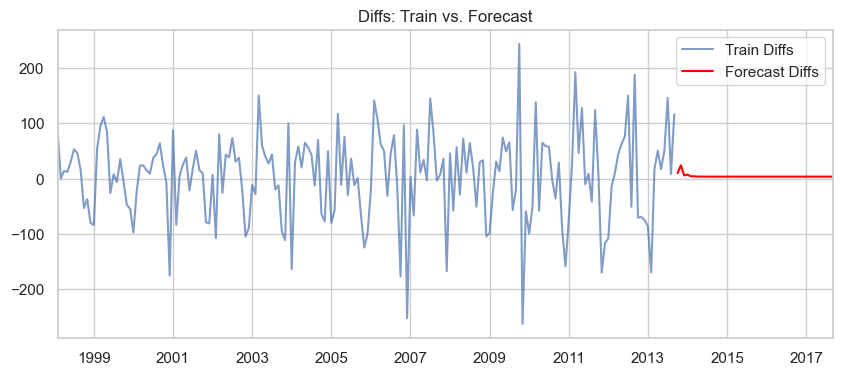

In [171]:
print("Meta:", result['meta'])
print("Diff Forecast Stats:", result['components']['diff'].describe())
print("Forecast Drift Check:", (result['forecast'].iloc[-1] - result['forecast'].iloc[0]) / len(test) * 12)

plt.figure(figsize=(10,4))
residual.plot(label='Train Diffs', alpha=0.7)
result['components']['diff'].plot(label='Forecast Diffs', color='red')
plt.title('Diffs: Train vs. Forecast')
plt.legend()
plt.show()

Performs badly :( For some reason ARIMA prediction itself is bad... 

In [159]:
model_ma = ARIMA(residual, order=(0, 0, 2))
fit_ma = model_ma.fit()
print(fit_ma.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  188
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1083.679
Date:                Tue, 07 Oct 2025   AIC                           2175.357
Time:                        23:02:20   BIC                           2188.303
Sample:                    02-01-1998   HQIC                          2180.602
                         - 09-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8676      7.462      0.518      0.604     -10.758      18.493
ma.L1          0.0498      0.058      0.860      0.390      -0.064       0.163
ma.L2          0.2547      0.070      3.621      0.0

In [172]:
result = reconstruct_diff_forecast(
    arima_results=fit_ma,
    diff_series=residual,
    original_series=train,
    forecast_index=test.index,
    true_series=test
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='MA on First Difference Forecast'
).show()

{'MAE': 352.5224085700041, 'RMSE': np.float64(389.2040003352601)}


In [160]:
model_arma = ARIMA(residual, order=(2, 0, 2))
fit_arma = model_arma.fit()
print(fit_arma.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  188
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1058.901
Date:                Tue, 07 Oct 2025   AIC                           2129.801
Time:                        23:02:20   BIC                           2149.220
Sample:                    02-01-1998   HQIC                          2137.669
                         - 09-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3598      1.247      1.892      0.058      -0.084       4.804
ar.L1          1.6611      0.045     36.717      0.000       1.572       1.750
ar.L2         -0.8539      0.040    -21.084      0.0

In [175]:
result = reconstruct_diff_forecast(
    arima_results=fit_arma,
    diff_series=residual,
    original_series=train,
    forecast_index=test.index,
    true_series=test
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='ARMA on First Difference Forecast'
).show()

{'MAE': 160.43860864278253, 'RMSE': np.float64(202.9615558406147)}


Performs a bit better :)

In [176]:
model_arima_d2_q2 = ARIMA(residual, order=(2, 1, 2))
fit_arima_d2_q2 = model_arima_d2_q2.fit()
print(fit_arima_d2_q2.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  188
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1082.141
Date:                Tue, 07 Oct 2025   AIC                           2174.283
Time:                        23:24:30   BIC                           2190.439
Sample:                    02-01-1998   HQIC                          2180.829
                         - 09-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1048      0.519     -0.202      0.840      -1.122       0.913
ar.L2          0.2000      0.084      2.369      0.018       0.035       0.365
ma.L1         -0.8344      1.218     -0.685      0.4

In [180]:
result = reconstruct_diff_forecast(
    arima_results=fit_arima_d2_q2,
    diff_series=residual,
    original_series=train,
    forecast_index=test.index,
    true_series=test
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='ARIMA on First Difference Forecast'
).show()

{'MAE': 364.35118507656716, 'RMSE': np.float64(400.6987409642426)}


Again bad :(

In [181]:
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        mod = ARIMA(residual, order=param)
        results = mod.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  188
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1058.901
Date:                Tue, 07 Oct 2025   AIC                           2129.801
Time:                        23:26:49   BIC                           2149.220
Sample:                    02-01-1998   HQIC                          2137.669
                         - 09-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3598      1.247      1.892      0.058      -0.084       4.804
ar.L1          1.6611      0.045     36.717      0.000       1.572       1.750
ar.L2         -0.8539      0.040    -21.084      0.0

In [182]:
result = reconstruct_diff_forecast(
    arima_results=best_model,
    diff_series=residual,
    original_series=train,
    forecast_index=test.index,
    true_series=test
)
print(result['metrics'])
plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=result['forecast'],
    y_column='Production',
    title='Tuned ARIMA on First Difference Forecast'
).show()

{'MAE': 160.43860864278253, 'RMSE': np.float64(202.9615558406147)}


Already seen it. A bit better than others, but...

#### Conclusion:
Best performance (by RMSE): **multiplicative decomposition + ARIMA(3;0;1)**

## Fun part

In [ ]:
from prophet import Prophet # FACEBOOK MODEL :)))))))

train_df = pd.DataFrame({'ds': train.index, 'y': train.values})

model = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
model.add_seasonality(name='monthly', period=30, fourier_order=5)

model.fit(train_df)

future = model.make_future_dataframe(periods=len(test), freq='MS', include_history=False)

forecast = model.predict(future)
forecast_y = forecast['yhat']
forecast_y.index = test.index

mae = mean_absolute_error(test, forecast_y)
rmse = np.sqrt(mean_squared_error(test, forecast_y))
print(f'Prophet MAE: {mae:.2f}, RMSE: {rmse:.2f}')

plot_model_results(
    train_data=train,
    val_data=test,
    predicted_val=forecast_y,
    y_column='Production',
    title='Prophet Forecast'
).show()

23:36:26 - cmdstanpy - INFO - Chain [1] start processing
23:36:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 135.41, RMSE: 161.00
